# Proto2 Winter Analysis Splines

### import necessary modules 

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date
import glob,os
import time
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import statistics
import math
from sklearn.metrics import mean_squared_error
import seaborn as sn



#### import functions I've written and that are locally stored

In [2]:
import sys
sys.path.append("/home/ehojeily/scripts/functions/")
from calibrate import calibrate
from generate_coefficients import generate_coefficients
from graph import norm_graph

### import proto 2 data 

In [3]:
proto2_despiked = pd.read_csv('/data/aq/nyserda/proto2/extended_analysis_data/despiked_proto2_ext.csv')
proto2_despiked = proto2_despiked.drop('Unnamed: 0',1)

In [4]:
proto2_despiked['datetime'] = pd.to_datetime(proto2_despiked['datefield'],format='%Y-%m-%d %H:%M:%S')
proto2_despiked = proto2_despiked.set_index('datetime')
houravg = proto2_despiked.resample('60min').mean()

In [5]:
houravg['time'] = houravg.reset_index().index # hours since deployment

### import dec reference data 

In [6]:
path_epa='/data/aq/dec/queens/epa_api/'
epa_filepaths = []
for file in sorted(os.listdir(path_epa)):
    epa_filepaths.append(path_epa+file)

#epa_from_files = (pd.read_csv(f,encoding='cp1252') for f in epa_filepaths) # https://stackoverflow.com/questions/33819557/unicodedecodeerror-utf-8-codec-while-reading-a-csv-file
epa_from_files = (pd.read_csv(f,encoding='cp437') for f in epa_filepaths) # https://stackoverflow.com/questions/9233027/unicodedecodeerror-charmap-codec-cant-decode-byte-x-in-position-y-character

epa_df = pd.concat(epa_from_files) 

In [7]:
#epa_df = epa_df.drop(columns=['Unnamed: 0'])

##### .. correct CO and ozone concentrations and calculate NO

In [8]:
epa_df['Carbon monoxide']=epa_df['Carbon monoxide']*1000
epa_df['Ozone']=epa_df['Ozone']*1000
epa_df['Nitrogen oxide']=epa_df['Oxides of nitrogen (NOx)']-epa_df['Nitrogen dioxide (NO2)']

In [9]:
epa_df=epa_df.set_index(pd.to_datetime(epa_df['date']))
#epa_table={42101:'Carbon monoxide',44201:'Ozone',42601:'Oxides of nitrogen (NOx)',42602:'Nitrogen dioxide (NO2)',88101:'PM2.5 - Local Conditions'}
epa_df.rename(columns={'PM2.5 - Local Conditions': 'PM2.5', 'Nitrogen dioxide (NO2)': 'NO2','Carbon monoxide':'CO', 
                       'Oxides of nitrogen (NOx)':'NOx','Ozone':'O3','Nitrogen oxide':'NO'},inplace=True)

## preparing data 

### we need to correct data for timezones and NaN values

#### .. timezone corrections

In [10]:
houravg = houravg.tz_localize(tz='UTC') # proto 2 is in UTC

In [11]:
epa_df = epa_df.tz_localize(tz='EST') # DEC is in est
epa_df = epa_df.tz_convert('UTC') # convert to UTC

#### .. match epa to proto2

In [12]:
# keep only DEC data that matches Proto2 data 
epa_df_matching_proto2=epa_df.loc[epa_df.index.isin(houravg.index)]
epa_df_matching_proto2;

#### .. choose only training period data 

In [13]:
#training_period_month = 'June'
training_period_month = 'Oct'

In [14]:
if training_period_month == 'Oct':
    DEC_training_month = epa_df_matching_proto2.loc['2021-10-01 00:00:00+00:00':'2021-10-31 23:00:00+00:00']
    training_dates = pd.read_csv('/home/ehojeily/scripts/training_dates_oct.txt')
    testing_dates = pd.read_csv('/home/ehojeily/scripts/testing_dates_oct.txt')
if training_period_month == 'June':
    DEC_training_month = epa_df_matching_proto2.loc['2021-06-01 00:00:00+00:00':'2021-06-30 23:00:00+00:00']
    testing_dates = pd.read_csv('/home/ehojeily/scripts/testing_dates_june.txt')
    training_dates = pd.read_csv('/home/ehojeily/scripts/training_dates_june.txt')  

proto2= houravg.loc[DEC_training_month.index]

## .. calculate what percentage of data for each pollutant contains a NaN value...

In [15]:
data = DEC_training_month.columns
data = data.drop(['date'])
for col in data:
    print(col, ' percent NaN = ', ((DEC_training_month[col].isna().sum()/len(DEC_training_month))*100).round(2),'%')

PM2.5  percent NaN =  0.13 %
NO2  percent NaN =  4.03 %
CO  percent NaN =  2.02 %
NOx  percent NaN =  4.03 %
O3  percent NaN =  1.34 %
NO  percent NaN =  4.03 %


#### .. remove NaN from DEC and reindex to match proto2

In [16]:
DEC_training_month = DEC_training_month.dropna(axis=0)
proto2_match2DEC = proto2.loc[proto2.index.isin(DEC_training_month.index)]
proto2_match2DEC;

### data are prepped! 

## Generate and Evaluate Regression Coefficients Using Fixed Random Sampling Method

### training and testing period dates are randomly determined but are not overlapping (meaning a date cannot be within the training and testing period)

### apply calibration

In [17]:
epa_table={42101:'CO',44201:'O3',42601:'NO',42602:'NO2',88101:'PM2.5'}
proto2_table={'42101':'CO_ppb','44201':'O3NO2_ppb','42601':'NO_ppb','42602':'NO2_ppb','88101':'pm25'}

In [18]:
coefficient_dict = {} 
pvalue_dict = {} 
Bcoefficient_dict = {} 
Bpvalue_dict = {} 
modified_training_input_dict = {}
BIC_gas_model_dict = {}

Working on ... CO
Optimizing by p-value... 
removed ...  Thigh
Model #  1
removed ...  Time
Model #  2
removed ...  Tlow
Model #  3
removed ...  RHlow
Model #  4
removed ...  RHhigh
Model #  5
Done
Calibrating using splines ...
Spline calibration model evaluation ...
TRAINING PERIOD
0.9619726457448297
[0.96197265 9.88047943]
20.815423470425493
6.512380948027233e-14
TESTING PERIOD
0.9599572091692314
[0.97366138 8.63721827]
20.14694805425167
0.7448720120479058


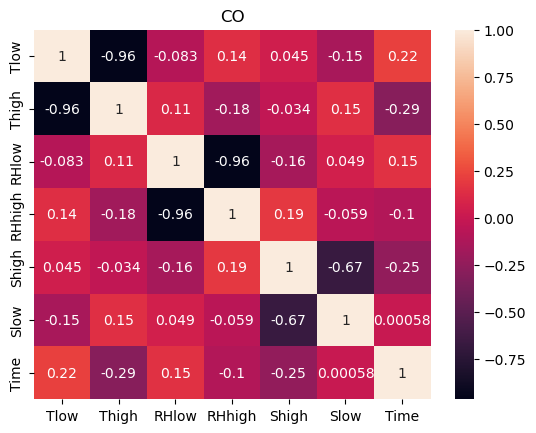

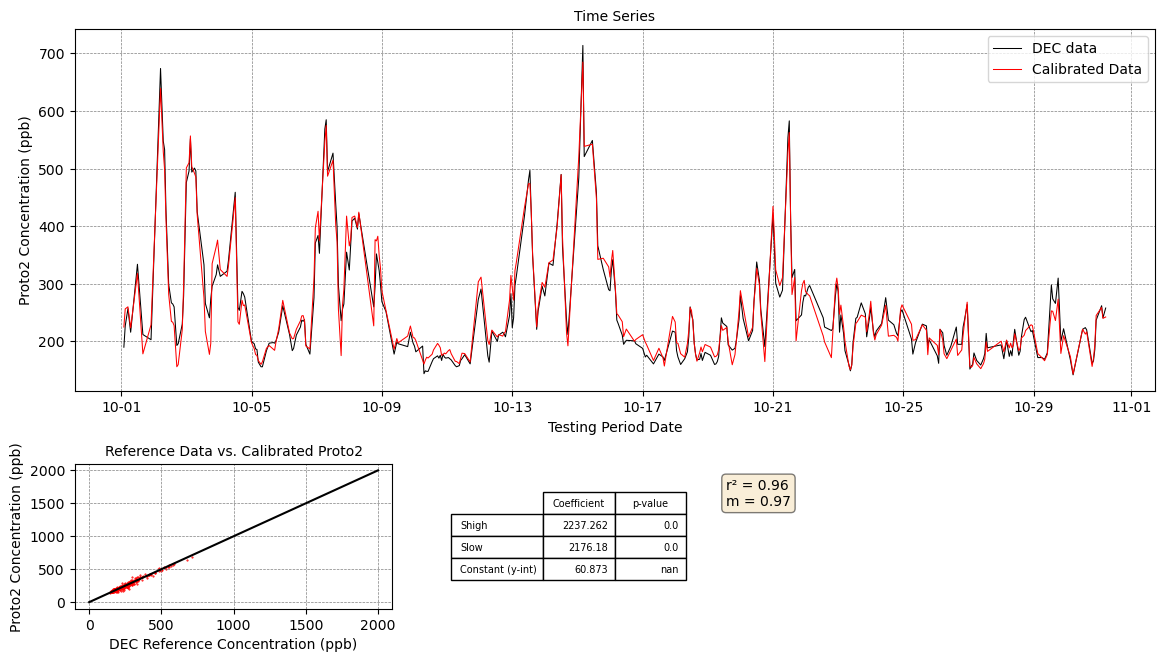

Working on ... O3
Optimizing by p-value... 
removed ...  CO_sensor
Model #  1
Done
Calibrating using splines ...
Spline calibration model evaluation ...
TRAINING PERIOD
0.9440241416592003
[0.94402414 1.41062417]
3.0971863519136162
-6.084980124908274e-13
TESTING PERIOD
0.9403220344067631
[0.92138263 1.92943666]
3.0596182690518328
-0.47131108845393865


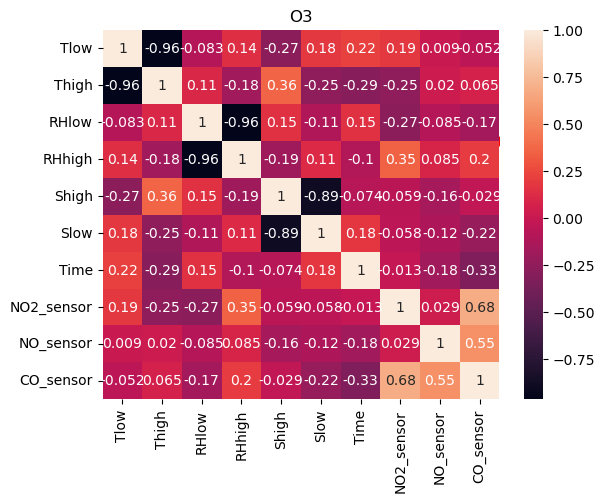

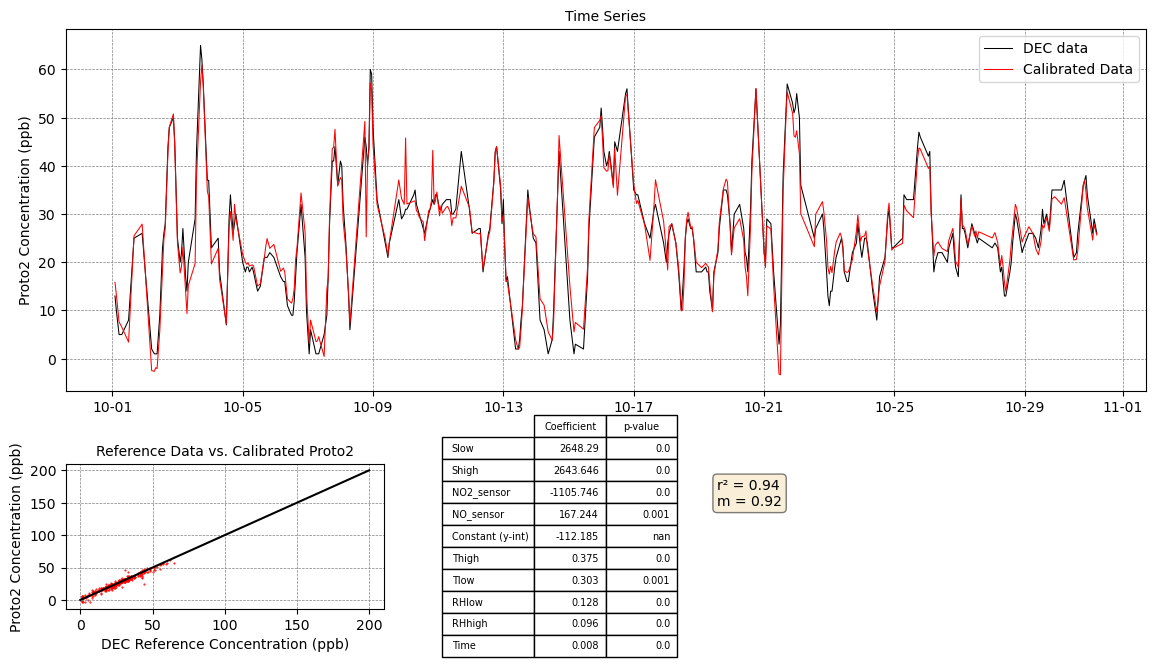

Working on ... NO
Optimizing by p-value... 
removed ...  RHlow
Model #  1
Done
Calibrating using splines ...
Spline calibration model evaluation ...
TRAINING PERIOD
0.9510608488798565
[0.95106085 0.15754423]
1.729992973723542
-3.244088921801577e-12
TESTING PERIOD
0.9345287901888798
[0.97779987 0.158776  ]
1.7302269724488506
2.896053512274363


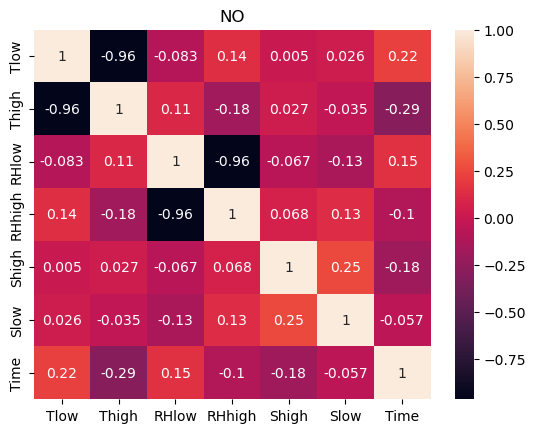

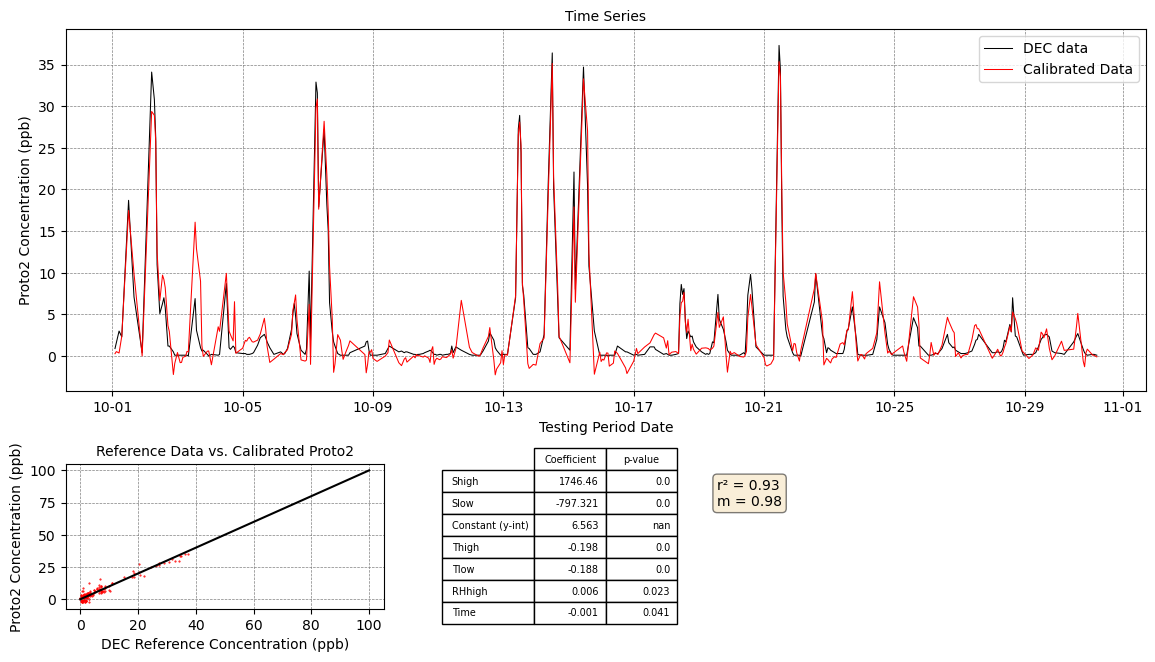

Working on ... NO2
Optimizing by p-value... 
Done
Calibrating using splines ...
Spline calibration model evaluation ...
TRAINING PERIOD
0.8763072645667765
[0.87630726 1.42163944]
2.8181221405740406
5.267832326833107e-12
TESTING PERIOD
0.8523278871548943
[0.85093342 1.76791678]
3.093153158565725
0.8934428191305096


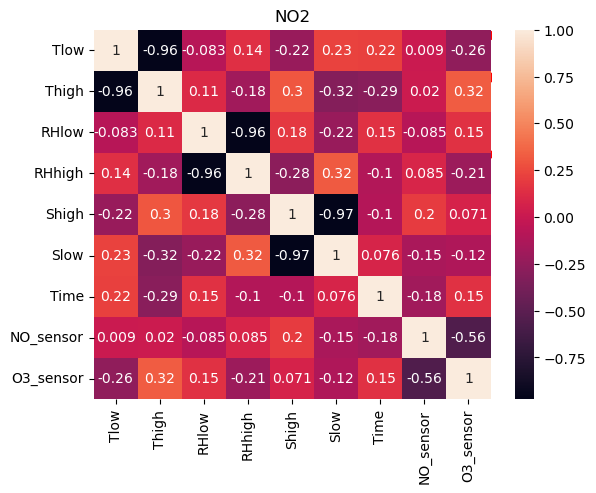

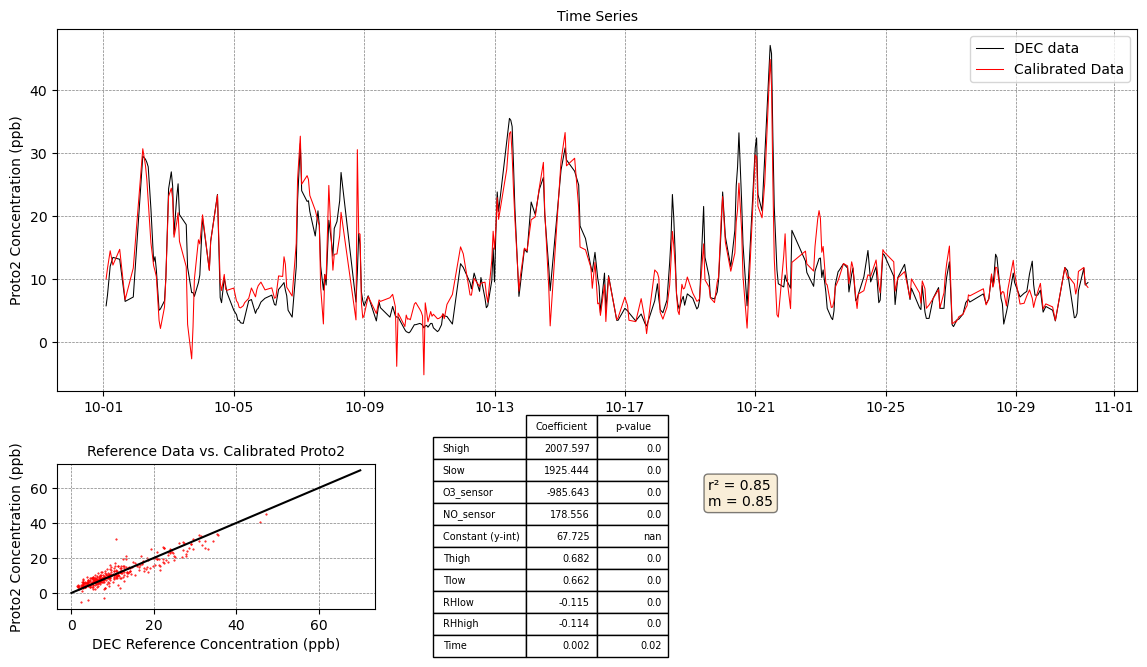

Working on ... pm25
Optimizing by p-value... 
removed ...  RHhigh
Model #  1
Done
Calibrating using splines ...
Spline calibration model evaluation ...
TRAINING PERIOD
0.794530797516751
[0.7945308  1.63186747]
1.7157922099935268
-6.49139734437689e-13
TESTING PERIOD
0.7774889822119435
[0.72945178 2.07372067]
1.7457034269912841
0.19771655410647068


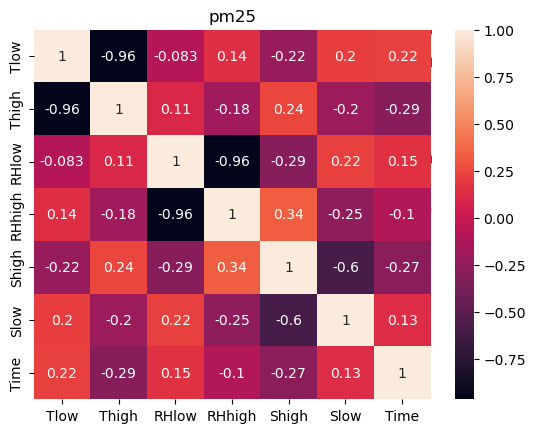

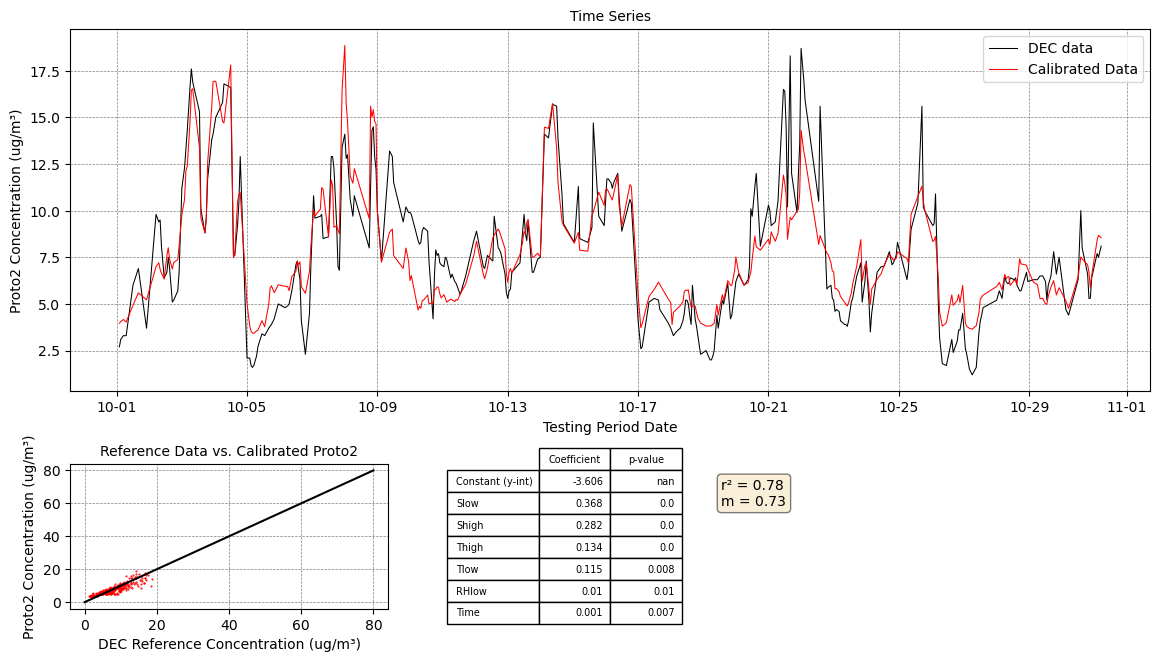

In [45]:
for var_id in [42101, 44201, 42601, 42602, 88101]:
#for var_id in [44201]:
    #get the concentration field that matches the corresponding var_id from observations and convert the time (here it's just a 5 hour conversion)
    epa_concentration_field=DEC_training_month[epa_table[var_id]].rename('value')
    #combine the observations and proto2 data into one dataset
    combined_df=pd.concat([epa_concentration_field,proto2_match2DEC],axis=1).dropna()
    #include some checks to see if the field is O3 or pm2.5
    #O3 needs to subtract NO2 because the sensor only records O3NO2
    #pm2.5 has a weird naming convention so this statement catches it and renames it to be consistent
    #basically we're just calculating the voltage difference here
        
    
    # Temp Hinge
    medianT = combined_df['temp_sht31_degC'].median()
    combined_df.loc[combined_df['temp_sht31_degC'] <= medianT, 'Tlow'] = 1
    combined_df.loc[combined_df['temp_sht31_degC'] > medianT, 'Tlow'] = 0
    combined_df.loc[combined_df['temp_sht31_degC'] > medianT, 'Thigh'] = 1
    combined_df.loc[combined_df['temp_sht31_degC'] <= medianT, 'Thigh'] = 0
    
    # RH Hinge
    medianRH = combined_df['rh_sht31_percent'].median()
    combined_df.loc[combined_df['rh_sht31_percent'] <= medianRH, 'RHlow'] = 1
    combined_df.loc[combined_df['rh_sht31_percent'] > medianRH, 'RHlow'] = 0
    combined_df.loc[combined_df['rh_sht31_percent'] > medianRH, 'RHhigh'] = 1
    combined_df.loc[combined_df['rh_sht31_percent'] <= medianRH, 'RHhigh'] = 0


    if var_id==44201:
        combined_df['O3_voltdiff']=(combined_df['O3NO2_V']-combined_df['NO2_V']).sub((combined_df['O3NO2_aux_V']-combined_df['NO2_aux_V']),axis=0)
        gname='O3'
        unit = '_ppb'
        pltunit = 'ppb'
    elif var_id in [88101]:
        gname='pm25'
        combined_df[gname+'_voltdiff']=combined_df[gname+'_std_ugm3'].copy()
        unit='_env_ugm3'
        pltunit = 'ug/m³'
    else:
        fname=proto2_table[str(var_id)]
        gname_loc=fname.find('ppb')-1
        gname=fname[:gname_loc]
        combined_df[gname+'_voltdiff']=combined_df[gname+'_V'].sub(combined_df[gname+'_aux_V'],axis=0)
        unit = '_ppb'
        pltunit = 'ppb'
    #perform some additional last minute qc on the data
    #this just tosses out times where the obs data is weird (i.e. is nan, ==0, ==-999, >10*mean)

    print('Working on ...',gname)
    ## adding sensor hinges
    if var_id == 44201 or var_id == 88101 or var_id == 42602 or var_id == 42601 or var_id == 42101:

        ''' SPLINES'''
        # hinges determined by scatterplots, adding cross-sensitivities ... 
        if var_id == 44201: # ozone
            sensor_hinge = 0.030
            combined_df['NO2_voltdiff']=combined_df['NO2_V'].sub(combined_df['NO2_aux_V'],axis=0)
            combined_df['NO_voltdiff']=combined_df['NO_V'].sub(combined_df['NO_aux_V'],axis=0)
            combined_df['CO_voltdiff']=combined_df['CO_V'].sub(combined_df['CO_aux_V'],axis=0)


        if var_id == 88101: # pm25
            sensor_hinge = 10
        if var_id == 42602: # NO2
            sensor_hinge = -0.025
            combined_df['NO_voltdiff']=combined_df['NO_V'].sub(combined_df['NO_aux_V'],axis=0)
            combined_df['O3_voltdiff']=(combined_df['O3NO2_V']-combined_df['NO2_V']).sub((combined_df['O3NO2_aux_V']-combined_df['NO2_aux_V']),axis=0)
        if var_id == 42601: # NO
            sensor_hinge = 0.000
        if var_id == 42101: # CO
            sensor_hinge = 0.15

        combined_df.loc[combined_df[gname+'_voltdiff'] <= sensor_hinge, 'Slow'] = 1
        combined_df.loc[combined_df[gname+'_voltdiff'] > sensor_hinge, 'Slow'] = 0
        combined_df.loc[combined_df[gname+'_voltdiff'] > sensor_hinge, 'Shigh'] = 1
        combined_df.loc[combined_df[gname+'_voltdiff'] <= sensor_hinge, 'Shigh'] = 0
    
        # delineate training and test periods
        combined_df_filtered_training=combined_df.loc[training_dates['date']] 
        combined_df_filtered_testing=combined_df.loc[testing_dates['date']]

        ## training fields using proto2_QC.csv 
        training_reference_concentrations = combined_df_filtered_training['value']

        if var_id == 42602: # NO2
            training_data = [combined_df_filtered_training['Tlow']*combined_df_filtered_training['temp_sht31_degC'],
                            combined_df_filtered_training['Thigh']*combined_df_filtered_training['temp_sht31_degC'],
                            combined_df_filtered_training['RHlow']*combined_df_filtered_training['rh_sht31_percent'],
                            combined_df_filtered_training['RHhigh']*combined_df_filtered_training['rh_sht31_percent'],
                            combined_df_filtered_training['Shigh']*combined_df_filtered_training[gname+'_voltdiff'],
                            combined_df_filtered_training['Slow']*combined_df_filtered_training[gname+'_voltdiff'],
                            combined_df_filtered_training['time'],combined_df_filtered_training['NO_voltdiff'],
                            combined_df_filtered_training['O3_voltdiff']]
            
            predictors = ['Tlow','Thigh','RHlow','RHhigh','Shigh','Slow','Time','NO_sensor','O3_sensor']
            training_data_input = pd.DataFrame(training_data, index=predictors).transpose()
       
            # testing fields using proto2_QC.csv 
            testing_reference_concentrations = combined_df_filtered_testing['value']
            testing_data = [combined_df_filtered_testing['Tlow']*combined_df_filtered_testing['temp_sht31_degC'],
                            combined_df_filtered_testing['Thigh']*combined_df_filtered_testing['temp_sht31_degC'],
                            combined_df_filtered_testing['RHlow']*combined_df_filtered_testing['rh_sht31_percent'],
                            combined_df_filtered_testing['RHhigh']*combined_df_filtered_testing['rh_sht31_percent'],
                            combined_df_filtered_testing['Shigh']*combined_df_filtered_testing[gname+'_voltdiff'],
                            combined_df_filtered_testing['Slow']*combined_df_filtered_testing[gname+'_voltdiff'],
                            combined_df_filtered_testing['time'],combined_df_filtered_testing['NO_voltdiff'],
                            combined_df_filtered_testing['O3_voltdiff']]
                                 
                                 
            testing_data_input = pd.DataFrame(testing_data, index=predictors).transpose()
            
        elif var_id == 44201: # O3
            training_data = [combined_df_filtered_training['Tlow']*combined_df_filtered_training['temp_sht31_degC'],
                            combined_df_filtered_training['Thigh']*combined_df_filtered_training['temp_sht31_degC'],
                            combined_df_filtered_training['RHlow']*combined_df_filtered_training['rh_sht31_percent'],
                            combined_df_filtered_training['RHhigh']*combined_df_filtered_training['rh_sht31_percent'],
                            combined_df_filtered_training['Shigh']*combined_df_filtered_training[gname+'_voltdiff'],
                            combined_df_filtered_training['Slow']*combined_df_filtered_training[gname+'_voltdiff'],
                            combined_df_filtered_training['time'],combined_df_filtered_training['NO2_voltdiff'],
                            combined_df_filtered_training['NO_voltdiff'], combined_df_filtered_training['CO_voltdiff']]
                     
            predictors = ['Tlow','Thigh','RHlow','RHhigh','Shigh','Slow','Time','NO2_sensor','NO_sensor','CO_sensor']
            training_data_input = pd.DataFrame(training_data, index=predictors).transpose()
       
            # testing fields using proto2_QC.csv 
            testing_reference_concentrations = combined_df_filtered_testing['value']
            testing_data = [combined_df_filtered_testing['Tlow']*combined_df_filtered_testing['temp_sht31_degC'],
                            combined_df_filtered_testing['Thigh']*combined_df_filtered_testing['temp_sht31_degC'],
                            combined_df_filtered_testing['RHlow']*combined_df_filtered_testing['rh_sht31_percent'],
                            combined_df_filtered_testing['RHhigh']*combined_df_filtered_testing['rh_sht31_percent'],
                            combined_df_filtered_testing['Shigh']*combined_df_filtered_testing[gname+'_voltdiff'],
                            combined_df_filtered_testing['Slow']*combined_df_filtered_testing[gname+'_voltdiff'],
                            combined_df_filtered_testing['time'],combined_df_filtered_testing['NO2_voltdiff'],
                            combined_df_filtered_testing['NO_voltdiff'], combined_df_filtered_testing['CO_voltdiff']]
                     
                                 
            
            testing_data_input = pd.DataFrame(testing_data, index=predictors).transpose()
        
        
        else:
            training_data = [combined_df_filtered_training['Tlow']*combined_df_filtered_training['temp_sht31_degC'],
                            combined_df_filtered_training['Thigh']*combined_df_filtered_training['temp_sht31_degC'],
                            combined_df_filtered_training['RHlow']*combined_df_filtered_training['rh_sht31_percent'],
                            combined_df_filtered_training['RHhigh']*combined_df_filtered_training['rh_sht31_percent'],
                            combined_df_filtered_training['Shigh']*combined_df_filtered_training[gname+'_voltdiff'],
                            combined_df_filtered_training['Slow']*combined_df_filtered_training[gname+'_voltdiff'],
                            combined_df_filtered_training['time']]
            
            predictors = ['Tlow','Thigh','RHlow','RHhigh','Shigh','Slow','Time']
            training_data_input = pd.DataFrame(training_data, index=predictors).transpose()
       
            # testing fields using proto2_QC.csv 
            testing_reference_concentrations = combined_df_filtered_testing['value']
            testing_data = [combined_df_filtered_testing['Tlow']*combined_df_filtered_testing['temp_sht31_degC'],
                            combined_df_filtered_testing['Thigh']*combined_df_filtered_testing['temp_sht31_degC'],
                            combined_df_filtered_testing['RHlow']*combined_df_filtered_testing['rh_sht31_percent'],
                            combined_df_filtered_testing['RHhigh']*combined_df_filtered_testing['rh_sht31_percent'],
                            combined_df_filtered_testing['Shigh']*combined_df_filtered_testing[gname+'_voltdiff'],
                            combined_df_filtered_testing['Slow']*combined_df_filtered_testing[gname+'_voltdiff'],
                            combined_df_filtered_testing['time']]
                                 
                                 
            testing_data_input = pd.DataFrame(testing_data, index=predictors).transpose()


    #print('Predictors before = ', training_data_input.columns)

    print('Optimizing by p-value... ')
    modified_training_data_input = training_data_input.copy()
    modified_testing_data_input = testing_data_input.copy()
    model_dict = {} 
    coefficients = generate_coefficients(training_data_input,training_reference_concentrations,'linear') # initial calibration 

    for i in range(len(training_data_input)):
        prev_BIC = coefficients['model'].bic
        model_dict[prev_BIC] = modified_training_data_input.columns
        del coefficients['pvalue_dict']['Y-intercept (constant term)']
        highest_pval_pred = max(coefficients['pvalue_dict'], key=coefficients['pvalue_dict'].get)

        if coefficients['pvalue_dict'][highest_pval_pred] > 0.05:
            modified_training_data_input = modified_training_data_input.drop(highest_pval_pred, axis=1)
            modified_testing_data_input = modified_testing_data_input.drop(highest_pval_pred, axis=1)

            opt_coefficients = generate_coefficients(modified_training_data_input,training_reference_concentrations,'linear')
            BIC = opt_coefficients['model'].bic
            print('removed ... ', highest_pval_pred)
            if prev_BIC < BIC:
                break
            else:
                print('Model # ',i+1)
                coefficients = opt_coefficients
                continue

        else:
            calibrated_data = calibrate(coefficients['coef_dict'], modified_testing_data_input)
            print('Done')
            break
    
    BIC_gas_model_dict[var_id] = model_dict
    coefficient_dict[var_id] = coefficients['coef_dict']
    pvalue_dict[var_id] = coefficients['pvalue_dict']
    modified_training_input_dict[var_id] = modified_training_data_input


    #print('Predictors after = ', training_data_input.columns)
    print('Calibrating using splines ...')
    coefficients = generate_coefficients(modified_training_data_input,training_reference_concentrations,'linear')
    calibrated_data = calibrate(coefficients['coef_dict'], modified_testing_data_input)
    training_calibrated_data = calibrate(coefficients['coef_dict'], modified_training_data_input)

    print('Spline calibration model evaluation ...')
    # delineate training and test periods
    combined_df_filtered_training=combined_df.loc[training_dates['date']] 
    combined_df_filtered_testing=combined_df.loc[testing_dates['date']]
    
    print('TRAINING PERIOD')
    n=len(training_reference_concentrations)
    training_r2 = (((n*(training_calibrated_data*training_reference_concentrations).sum())-(training_calibrated_data.sum()*training_reference_concentrations.sum()))\
        /np.sqrt((n*(training_reference_concentrations**2).sum()-(training_reference_concentrations).sum()**2)*\
                 (n*(training_calibrated_data**2).sum()-training_calibrated_data.sum()**2)))**2
    training_slope = np.polyfit(training_reference_concentrations,training_calibrated_data,1)
    training_rmse = mean_squared_error(training_reference_concentrations, training_calibrated_data, squared=False)
    training_percentbias = ((np.sum(training_calibrated_data)-np.sum(training_reference_concentrations))/(np.sum(training_reference_concentrations)))*100


    print(training_r2)
    print(training_slope)
    print(training_rmse)
    print(training_percentbias)

    print('TESTING PERIOD')
    n=len(testing_reference_concentrations)
    testing_r2 = (((n*(calibrated_data*testing_reference_concentrations).sum())-(calibrated_data.sum()*testing_reference_concentrations.sum()))\
        /np.sqrt((n*(testing_reference_concentrations**2).sum()-(testing_reference_concentrations).sum()**2)*\
                 (n*(calibrated_data**2).sum()-calibrated_data.sum()**2)))**2
    testing_slope = np.polyfit(testing_reference_concentrations,calibrated_data,1)
    testing_rmse = mean_squared_error(testing_reference_concentrations, calibrated_data, squared=False)
    testing_percentbias = ((np.sum(calibrated_data)-np.sum(testing_reference_concentrations))/(np.sum(testing_reference_concentrations)))*100

    print(testing_r2)
    print(testing_slope)
    print(testing_rmse)
    print(testing_percentbias)
    
    '''PLOT TIME :)'''
    testing_period = testing_reference_concentrations.index
    training_period = training_reference_concentrations.index

    '''
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
    axes[0].scatter(combined_df_filtered_testing[gname+'_voltdiff'], testing_reference_concentrations, color='magenta')
    axes[0].set_title('Uncalibrated Data for '+gname)
    axes[0].set_xlabel('Uncalibrated Proto2 '+gname)
    axes[0].set_ylabel('Reference')


    axes[1].scatter(calibrated_data, testing_reference_concentrations, color='blue')
    axes[1].set_title('Calibrated Data for '+gname+' (Spline MLR)')
    axes[1].set_xlabel('Calibrated Proto2 '+gname)
    axes[1].set_ylabel('Reference')

    fig.tight_layout()

    '''
    plt.title(gname)
    plt.scatter(training_calibrated_data,coefficients['model'].resid, color='red')
    corr_matrix = training_data_input.corr()
    sn.heatmap(corr_matrix, annot=True)
    norm_graph(var_id,calibrated_data, coefficient_dict[var_id], pvalue_dict[var_id],
                testing_reference_concentrations, testing_period, gname, linear_color='red')
    





# Calibrate winter months

In [24]:
#september = (epa_df_matching_proto2['date'] >= '2021-09-01  00:00:00') & (epa_df_matching_proto2['date'] <= '2021-09-31 23:00:00') 
DEC_wint = epa_df_matching_proto2.loc['2021-12-01 00:00:00+00:00':'2022-04-01 00:00:00+00:00']
proto2_wint = houravg.loc[DEC_wint.index]
proto2_wint_match2DEC = proto2_wint.loc[proto2_wint.index.isin(DEC_wint.index)]
proto2_wint_match2DEC;

TESTING PERIOD
0.9372142426570159
[ 0.67239802 33.72045518]
88.60825650529469
-21.474147186554635


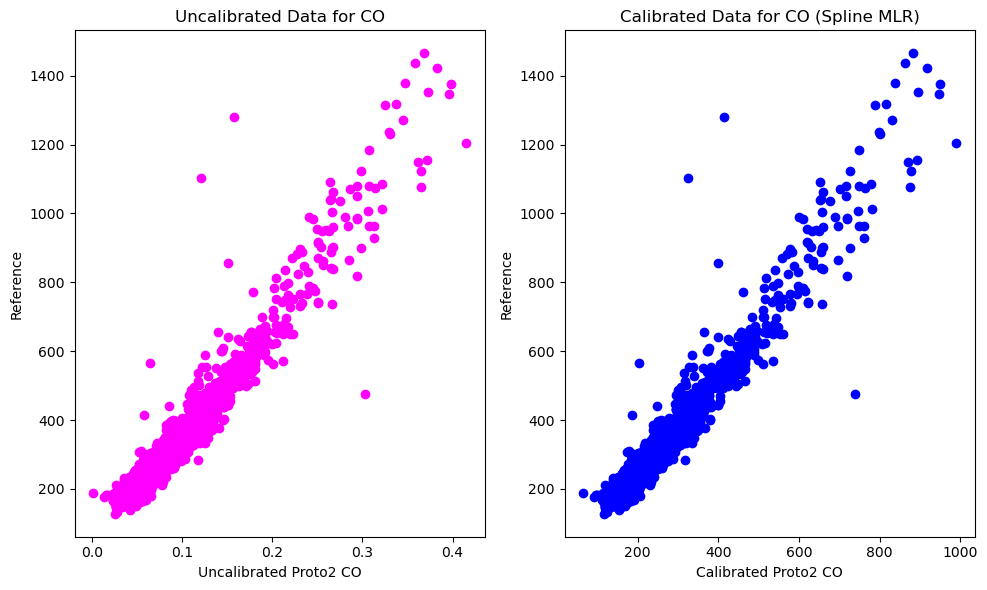

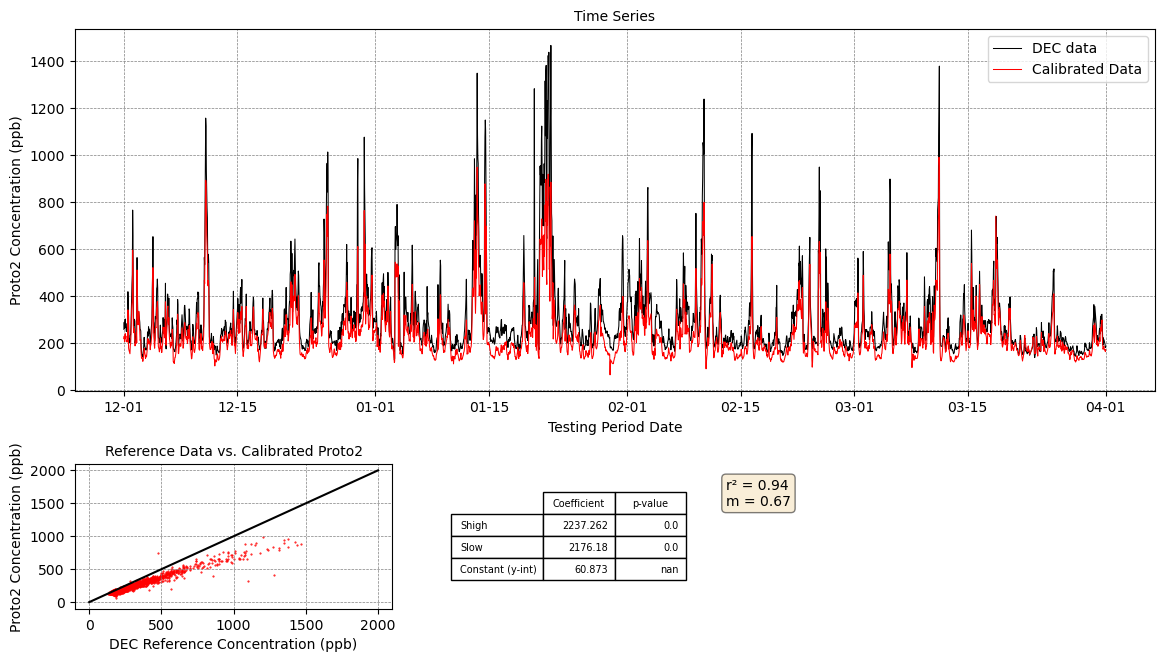

TESTING PERIOD
0.7408454483600496
[0.99223984 0.52981947]
7.006957823932353
1.5279687640768334


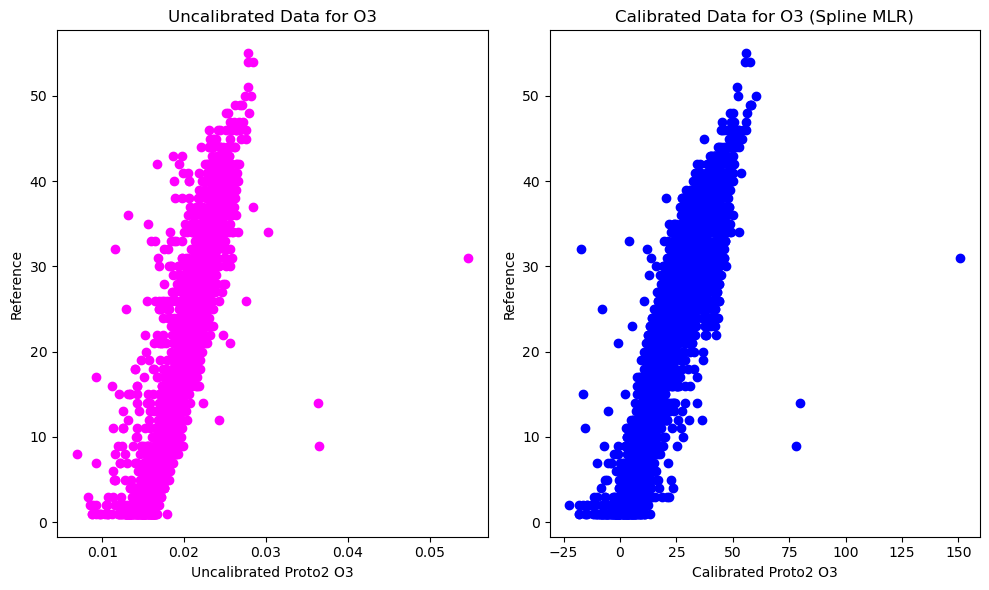

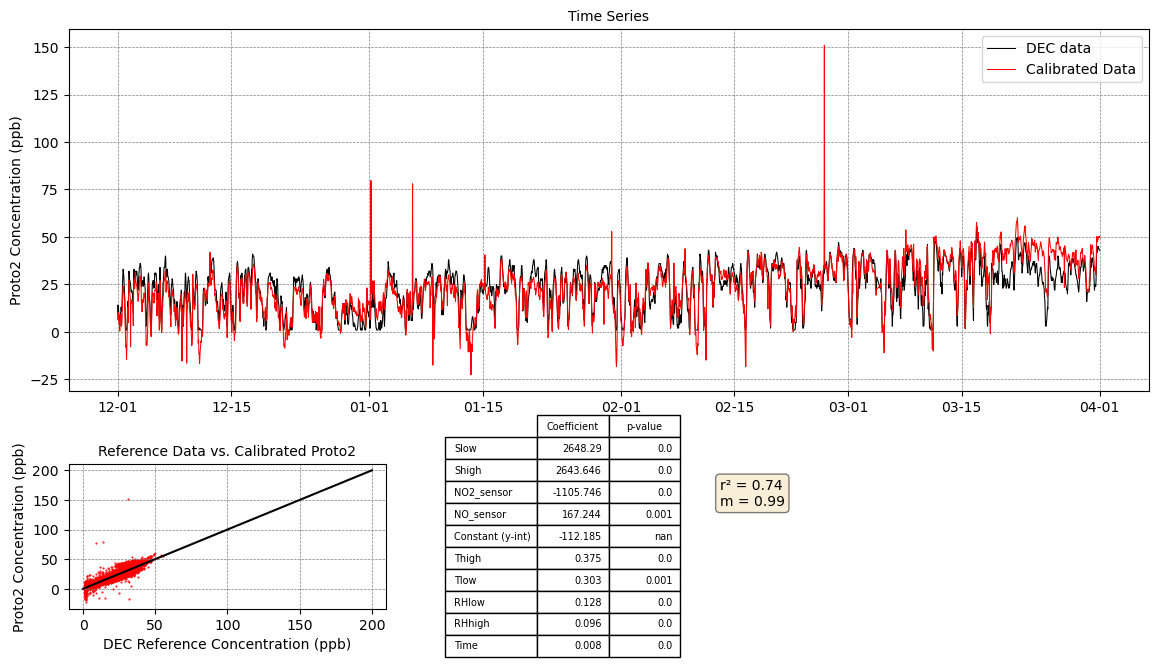

TESTING PERIOD
0.9325030473896995
[ 0.85282258 -0.07331266]
2.3820886529922003
-16.27063427853143


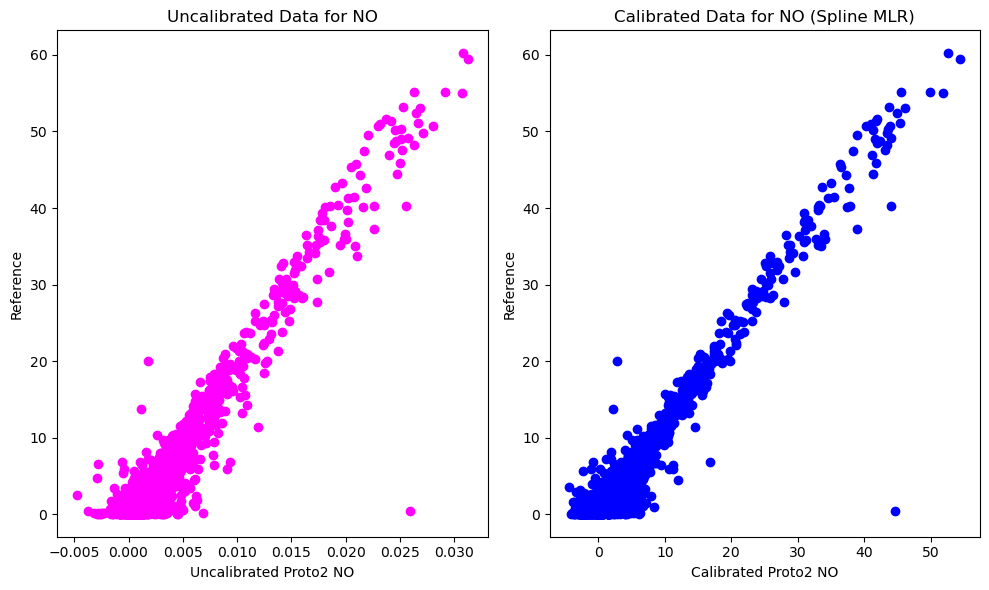

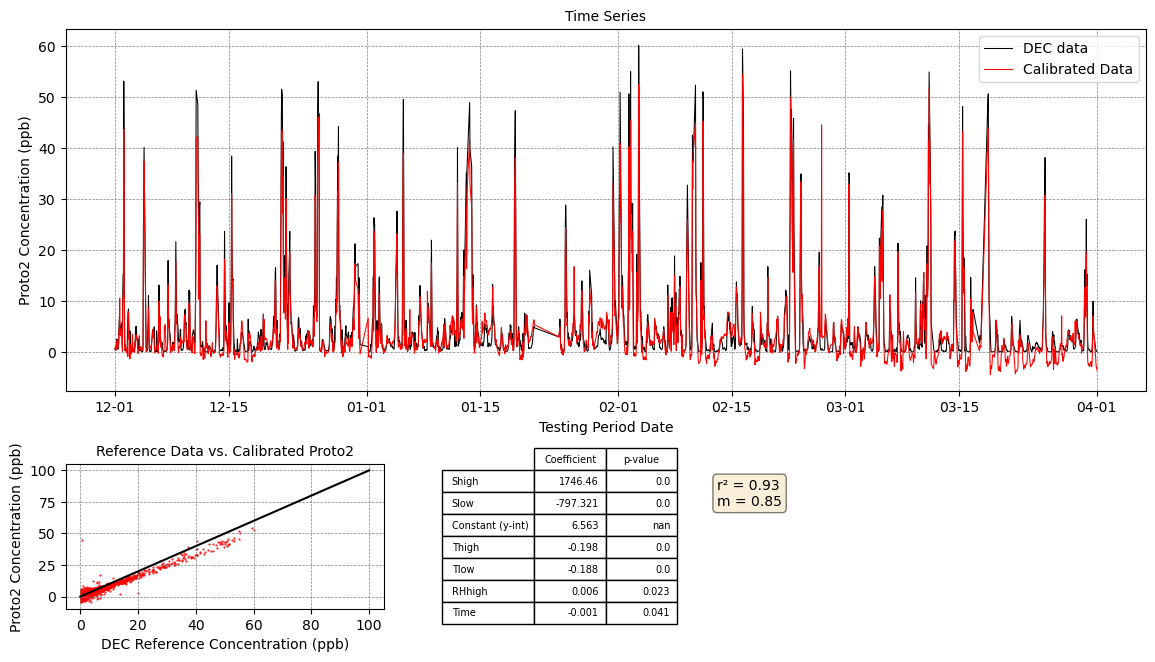

TESTING PERIOD
0.6732206917975769
[0.74687729 4.29681759]
5.998483813201338
-0.4678326613500125


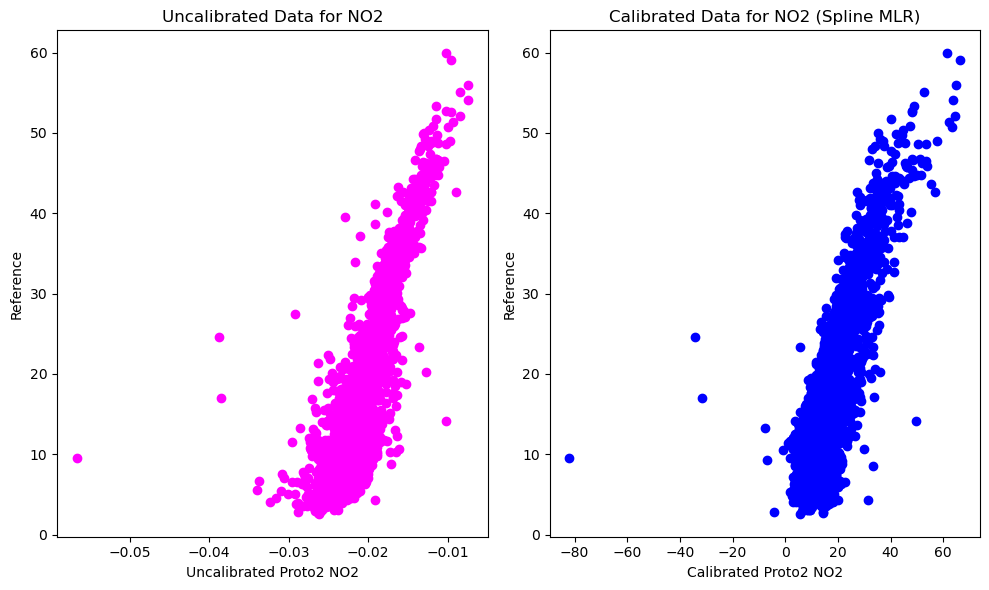

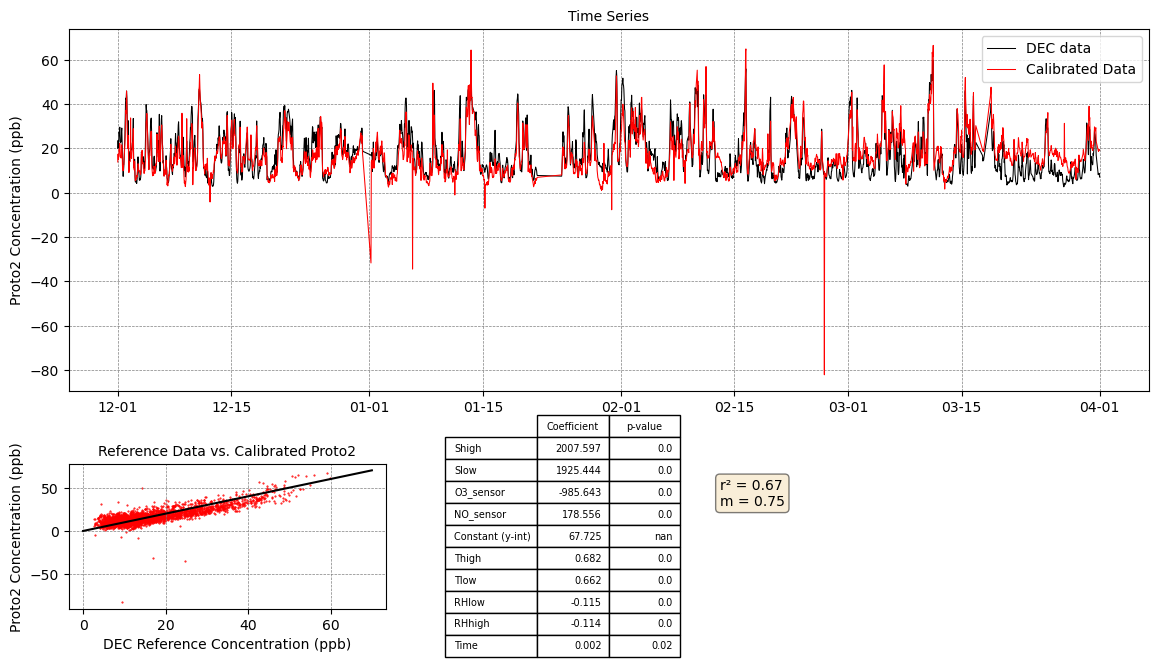

TESTING PERIOD
0.8221317027929044
[0.55460328 4.49802365]
3.557067058745185
-3.3615834218721954


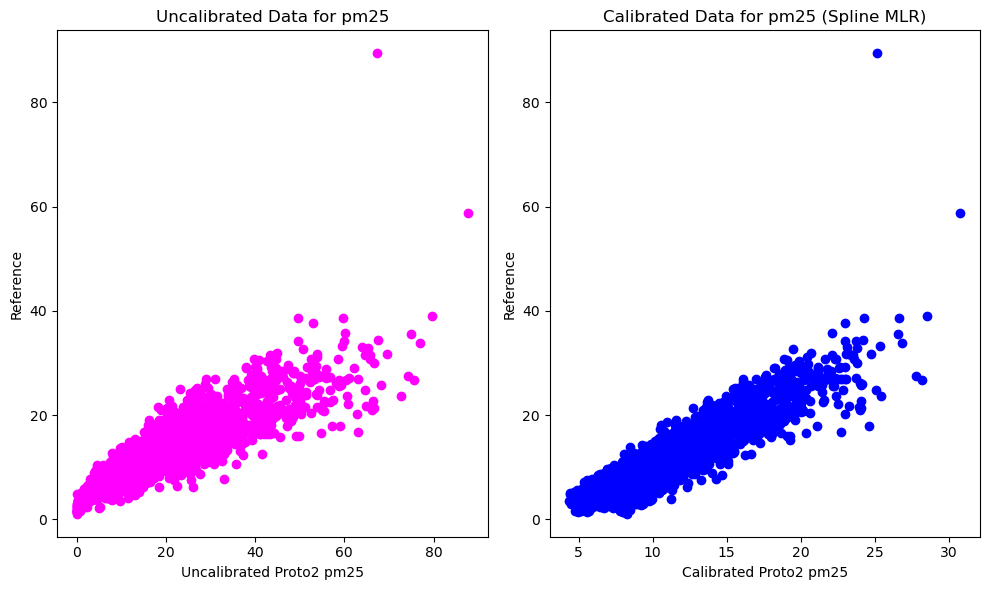

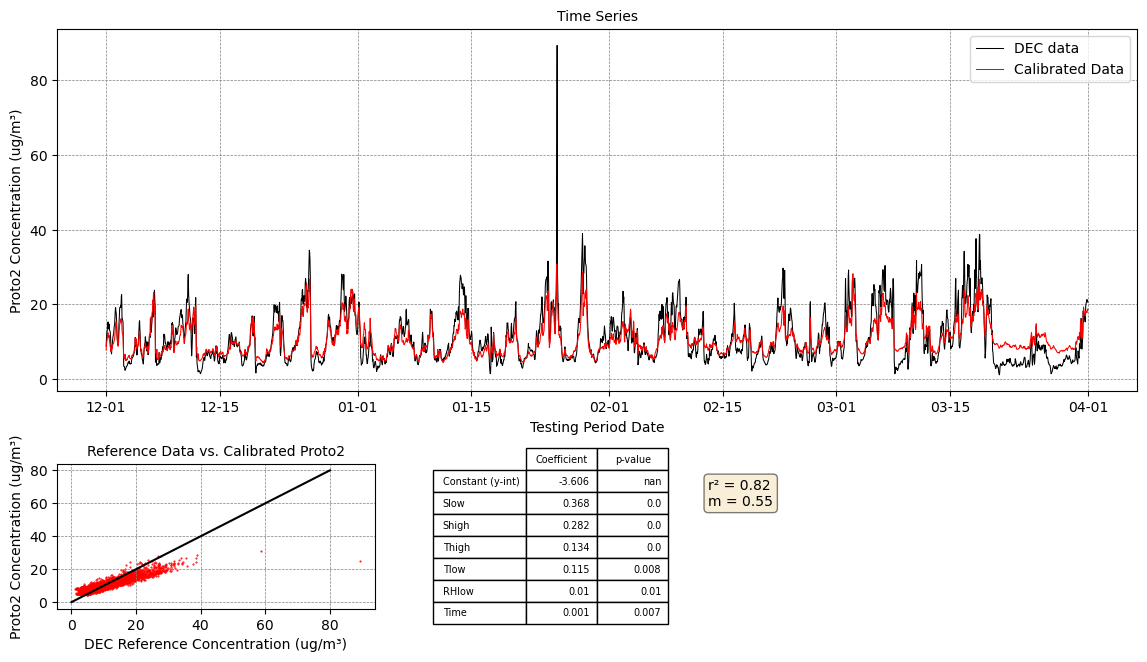

In [28]:
for var_id in [42101, 44201, 42601, 42602, 88101]:
#for var_id in [44201]:

#get the concentration field that matches the corresponding var_id from observations and convert the time (here it's just a 5 hour conversion)
    epa_concentration_field=DEC_wint[epa_table[var_id]].rename('value')
    #combine the observations and proto2 data into one dataset
    combined_df=pd.concat([epa_concentration_field,proto2_wint_match2DEC],axis=1).dropna()
    #include some checks to see if the field is O3 or pm2.5
    #O3 needs to subtract NO2 because the sensor only records O3NO2
    #pm2.5 has a weird naming convention so this statement catches it and renames it to be consistent
    #basically we're just calculating the voltage difference here
    if var_id==44201:
        combined_df['O3_voltdiff']=(combined_df['O3NO2_V']-combined_df['NO2_V']).sub((combined_df['O3NO2_aux_V']-combined_df['NO2_aux_V']),axis=0)
        gname='O3'
        unit = '_ppb'
        pltunit = 'ppb'
    elif var_id in [88101]:
        gname='pm25'
        combined_df[gname+'_voltdiff']=combined_df[gname+'_std_ugm3'].copy()
        unit='_env_ugm3'
        pltunit = 'ug/m³'
    else:
        fname=proto2_table[str(var_id)]
        gname_loc=fname.find('ppb')-1
        gname=fname[:gname_loc]
        combined_df[gname+'_voltdiff']=combined_df[gname+'_V'].sub(combined_df[gname+'_aux_V'],axis=0)
        unit = '_ppb'
        pltunit = 'ppb'
        
    combined_df_filtered=combined_df.loc[(~np.isnan(combined_df['value'])) & (combined_df['value']>0) 
                                         & (combined_df['value']!=0) & (combined_df['value']!=-999) 
                                         & (abs(combined_df['value'])<(abs(combined_df['value']).mean()*10))]
    
    combined_df=combined_df_filtered
    
    # Temp Hinge
    #medianT = combined_df['temp_sht31_degC'].median()
    combined_df.loc[combined_df['temp_sht31_degC'] <= medianT, 'Tlow'] = 1
    combined_df.loc[combined_df['temp_sht31_degC'] > medianT, 'Tlow'] = 0
    combined_df.loc[combined_df['temp_sht31_degC'] > medianT, 'Thigh'] = 1
    combined_df.loc[combined_df['temp_sht31_degC'] <= medianT, 'Thigh'] = 0
    
    # RH Hinge
    #medianRH = combined_df['rh_sht31_percent'].median()
    combined_df.loc[combined_df['rh_sht31_percent'] <= medianRH, 'RHlow'] = 1
    combined_df.loc[combined_df['rh_sht31_percent'] > medianRH, 'RHlow'] = 0
    combined_df.loc[combined_df['rh_sht31_percent'] > medianRH, 'RHhigh'] = 1
    combined_df.loc[combined_df['rh_sht31_percent'] <= medianRH, 'RHhigh'] = 0
        

    ## adding sensor hinges
    if var_id == 44201 or var_id == 88101 or var_id == 42602 or var_id == 42601 or var_id == 42101:
        ''' SPLINES'''
        # hinges determined by scatterplots, adding cross-sensitivities ... 
        if var_id == 44201: # ozone
            sensor_hinge = 0.030
            combined_df['NO2_voltdiff']=combined_df['NO2_V'].sub(combined_df['NO2_aux_V'],axis=0)
            combined_df['NO_voltdiff']=combined_df['NO_V'].sub(combined_df['NO_aux_V'],axis=0)
            combined_df['CO_voltdiff']=combined_df['CO_V'].sub(combined_df['CO_aux_V'],axis=0)

        if var_id == 88101: # pm25
            sensor_hinge = 10
        if var_id == 42602: # NO2
            sensor_hinge = -0.025
            combined_df['NO_voltdiff']=combined_df['NO_V'].sub(combined_df['NO_aux_V'],axis=0)
            combined_df['O3_voltdiff']=(combined_df['O3NO2_V']-combined_df['NO2_V']).sub((combined_df['O3NO2_aux_V']-combined_df['NO2_aux_V']),axis=0)
        if var_id == 42601: # NO
            sensor_hinge = 0.000
        if var_id == 42101: # CO
            sensor_hinge = 0.15

        combined_df.loc[combined_df[gname+'_voltdiff'] <= sensor_hinge, 'Slow'] = 1
        combined_df.loc[combined_df[gname+'_voltdiff'] > sensor_hinge, 'Slow'] = 0
        combined_df.loc[combined_df[gname+'_voltdiff'] > sensor_hinge, 'Shigh'] = 1
        combined_df.loc[combined_df[gname+'_voltdiff'] <= sensor_hinge, 'Shigh'] = 0
    
        # delineate training and test periods
        combined_df_filtered_testing=combined_df

        ## training fields using proto2_QC.csv 
        training_reference_concentrations = combined_df_filtered_training['value']
        if var_id == 42602: # NO2
       
            # testing fields using proto2_QC.csv 
            testing_reference_concentrations = combined_df_filtered_testing['value']
            testing_data = [combined_df_filtered_testing['Tlow']*combined_df_filtered_testing['temp_sht31_degC'],
                            combined_df_filtered_testing['Thigh']*combined_df_filtered_testing['temp_sht31_degC'],
                            combined_df_filtered_testing['RHlow']*combined_df_filtered_testing['rh_sht31_percent'],
                            combined_df_filtered_testing['RHhigh']*combined_df_filtered_testing['rh_sht31_percent'],
                            combined_df_filtered_testing['Shigh']*combined_df_filtered_testing[gname+'_voltdiff'],
                            combined_df_filtered_testing['Slow']*combined_df_filtered_testing[gname+'_voltdiff'],
                            combined_df_filtered_testing['time'],combined_df_filtered_testing['NO_voltdiff'],
                            combined_df_filtered_testing['O3_voltdiff']]
                            
            predictors = ['Tlow','Thigh','RHlow','RHhigh','Shigh','Slow','Time', 'NO_sensor','O3_sensor']
        elif var_id == 44201: # O3   
            # testing fields using proto2_QC.csv 
            testing_reference_concentrations = combined_df_filtered_testing['value']
            testing_data = [combined_df_filtered_testing['Tlow']*combined_df_filtered_testing['temp_sht31_degC'],
                            combined_df_filtered_testing['Thigh']*combined_df_filtered_testing['temp_sht31_degC'],
                            combined_df_filtered_testing['RHlow']*combined_df_filtered_testing['rh_sht31_percent'],
                            combined_df_filtered_testing['RHhigh']*combined_df_filtered_testing['rh_sht31_percent'],
                            combined_df_filtered_testing['Shigh']*combined_df_filtered_testing[gname+'_voltdiff'],
                            combined_df_filtered_testing['Slow']*combined_df_filtered_testing[gname+'_voltdiff'],
                            combined_df_filtered_testing['time'],combined_df_filtered_testing['NO2_voltdiff'],
                            combined_df_filtered_testing['NO2_voltdiff'], combined_df_filtered_testing['CO_voltdiff']]
            
            
            predictors = ['Tlow','Thigh','RHlow','RHhigh','Shigh','Slow','Time', 'NO2_sensor','NO_sensor','CO_sensor']  

        else:
            # testing fields using proto2_QC.csv 
            testing_reference_concentrations = combined_df_filtered_testing['value']
            testing_data = [combined_df_filtered_testing['Tlow']*combined_df_filtered_testing['temp_sht31_degC'],
                            combined_df_filtered_testing['Thigh']*combined_df_filtered_testing['temp_sht31_degC'],
                            combined_df_filtered_testing['RHlow']*combined_df_filtered_testing['rh_sht31_percent'],
                            combined_df_filtered_testing['RHhigh']*combined_df_filtered_testing['rh_sht31_percent'],
                            combined_df_filtered_testing['Shigh']*combined_df_filtered_testing[gname+'_voltdiff'],
                            combined_df_filtered_testing['Slow']*combined_df_filtered_testing[gname+'_voltdiff'],
                            combined_df_filtered_testing['time']]
                     

            predictors = ['Tlow','Thigh','RHlow','RHhigh','Shigh','Slow','Time'] 

        
        testing_data_input = pd.DataFrame(testing_data, index=predictors).transpose()      
        selected_predictors =  modified_training_input_dict[var_id].columns.to_list()
        dropped_predictors = [] 

        for predictor in predictors:
            if predictor not in selected_predictors:
                dropped_predictors.append(predictor)

        #testing_data_input = pd.DataFrame(testing_data, index=all_pred).transpose()
        testing_data_input = testing_data_input.drop(columns=dropped_predictors)

        calibrated_data = calibrate(coefficient_dict[var_id], testing_data_input)


    print('TESTING PERIOD')
    n=len(testing_reference_concentrations)
    testing_r2 = (((n*(calibrated_data*testing_reference_concentrations).sum())-(calibrated_data.sum()*testing_reference_concentrations.sum()))\
        /np.sqrt((n*(testing_reference_concentrations**2).sum()-(testing_reference_concentrations).sum()**2)*\
                 (n*(calibrated_data**2).sum()-calibrated_data.sum()**2)))**2
    testing_slope = np.polyfit(testing_reference_concentrations,calibrated_data,1)
    testing_rmse = mean_squared_error(testing_reference_concentrations, calibrated_data, squared=False)
    testing_percentbias = ((np.mean(calibrated_data)-np.mean(testing_reference_concentrations))/(np.mean(testing_reference_concentrations)))*100

    print(testing_r2)
    print(testing_slope)
    print(testing_rmse)
    print(testing_percentbias)

    '''PLOT TIME :)'''
    testing_period = testing_reference_concentrations.index
    training_period = training_reference_concentrations.index

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
    axes[0].scatter(combined_df_filtered_testing[gname+'_voltdiff'], testing_reference_concentrations, color='magenta')
    axes[0].set_title('Uncalibrated Data for '+gname)
    axes[0].set_xlabel('Uncalibrated Proto2 '+gname)
    axes[0].set_ylabel('Reference')


    axes[1].scatter(calibrated_data, testing_reference_concentrations, color='blue')
    axes[1].set_title('Calibrated Data for '+gname+' (Spline MLR)')
    axes[1].set_xlabel('Calibrated Proto2 '+gname)
    axes[1].set_ylabel('Reference')


    
    fig.tight_layout()

    norm_graph(var_id,calibrated_data, coefficient_dict[var_id], pvalue_dict[var_id],
                testing_reference_concentrations, testing_period, gname, linear_color='red')
    




<AxesSubplot:>

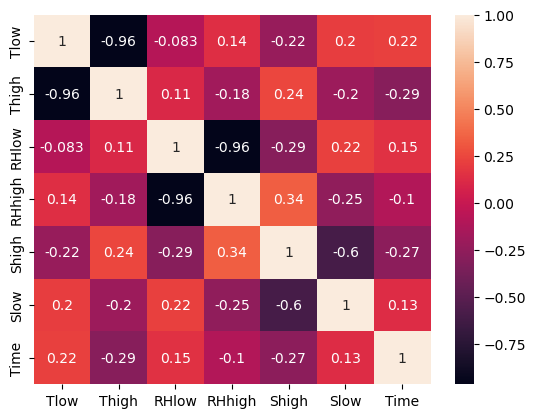

In [43]:
import seaborn as sn

corr_matrix = training_data_input.corr()
sn.heatmap(corr_matrix, annot=True)
